# Digitally controlled filter

Requirements:

- Input: float frequency_Hz, float sample_rate_Hz.
- Must be automatable (i.e. real time coefficient calculations).
- Must work as both a high-pass and low-pass filter.

References:

- Basic filter structure from Stilson and Smith 1996 Analyzing the Moog VCF with Considerations for Digital Implementation
- Referred to in Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis page 26.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

SAMPLE_RATE_Hz = 44100
F_START_Hz = 20
F_STOP_Hz = 20e3
AMPLITUDE = 1.0
DURATION_s = 10.0

HP_TARGET_Hz = 5000.0
LP_TARGET_Hz = 15000.0

In [47]:
b = 0.02
a = (0.8-b) / (127*127)
print(a*63*63 + b)
print(a*0*0 + b)
print(a*127*127 + b)

0.21194122388244777
0.02
0.8


In [48]:
def get_chirp_frequency():
    return np.linspace(F_START_Hz, F_STOP_Hz, int(DURATION_s*SAMPLE_RATE_Hz))
    
def get_chirp():
    t = np.arange(int(DURATION_s*SAMPLE_RATE_Hz))/SAMPLE_RATE_Hz
    x = AMPLITUDE * scipy.signal.chirp(t, f0=F_START_Hz, f1=F_STOP_Hz, t1=max(t), method="linear")
    return np.array(x, dtype=float)

In [53]:
def onepole(x, g, x1, y1):
    v = 0.8*x + 0.2*x1
    return (v-y1)*g + y1

def lp_filter(x_all, g):
    w = np.zeros(5) # Current sample
    w1 = np.zeros(5) # Delay line (must be static)
    y_all = np.zeros(len(x_all), dtype=float)
    
    for n in range(len(x_all)):
        w[0] = x[n]
        w[1] = onepole(w[0], g, w1[0], w1[1])
        w[2] = onepole(w[1], g, w1[1], w1[2])
        w[3] = onepole(w[2], g, w1[2], w1[3])
        w[4] = onepole(w[3], g, w1[3], w1[4])

        y_all[n] = w[4]
        
        # Update delay line
        for n in range(5):
            w1[n] = w[n]
    
    return y_all

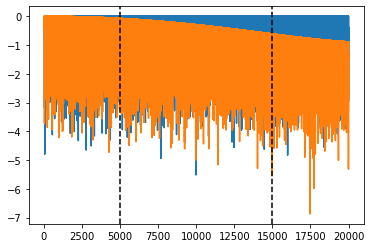

In [64]:
f = get_chirp_frequency()
x = get_chirp()
y1 = lp_filter(x, g=0.99)

p = lambda X: plt.plot(f, np.log10(np.abs(X)))
p(x)
p(y1)

for marker in [HP_TARGET_Hz, LP_TARGET_Hz]:
    plt.axvline(marker, color="black", linestyle="--")